# XGBoost Trading Strategy

<div class="alert alert-block alert-info">
<b>Note:</b> The data used in this notebook is sourced from FirstRate Data. To run this notebook, the FirstRate Data, or equivalent data in the same format, is required. </div>

### 1. Imports

In [1]:
# forecast monthly births with xgboost
import numpy as np
from numpy import asarray
# from pandas import read_csv, DataFrame, concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot as plt
import csv
import pandas as pd

import os, sys

sys.path.append(os.path.abspath('../pysystemtrade'))

from sysdata.sim.csv_futures_sim_data import csvFuturesSimData
from sysquant.estimators.vol import robust_vol_calc
from systems.accounts.account_forecast import pandl_for_instrument_forecast


### 2. Read in and Pre-process Data

In [2]:
CRUDE_OIL = 'CL'
NAT_GAS = 'NG'
BRENT_CRUDE = 'BZ'
GAS = 'RB'
HEAT_OIL = 'HO'

fuel_futures = [CRUDE_OIL, NAT_GAS, BRENT_CRUDE, GAS, HEAT_OIL]

S_P_500 = 'ES'
NASDAQ = 'NQ'
EUROSTOXX = 'FX'
DAX = 'DY'
FT_100 = 'X'

equity_futures = [S_P_500, NASDAQ, EUROSTOXX, DAX, FT_100]

In [3]:
# Define the data paths according to the structure of the project
FUEL_FUTURES_PATH = '../data/fuel_first_rate_data_R_prices.parquet'
EQUITY_FUTURES_PATH = '../data/equity_indices_first_rate_data_R_prices.parquet'

CSV_PATH = '../pysystemtrade/data/firstrate_futures/xgboost'

In [4]:
# Read in data
start_datetime = '2018-01-02'

fuel_futures_data = pd.read_parquet(FUEL_FUTURES_PATH)
equity_futures_data = pd.read_parquet(EQUITY_FUTURES_PATH)

In [5]:
# Function to convert data in a futures data file into individual csv files
def convert_parquet_to_csv(src_dataframe: pd.DataFrame, dst_path: str, symbols: list) -> None:
    """_summary_

    Args:
        src_path (str): _description_
        dst_path (str): _description_
    """

    for i, column in enumerate(symbols):

        dst_filename = dst_path + f'/{symbols[i]}_daily.csv'

        # Resample the dataframe to have daily prices as we will predict the daily average
        curr_futures_data_daily_avg = src_dataframe[symbols[i]].resample("D").mean().dropna()
    
        curr_futures_data_daily_avg.to_csv(dst_filename, header=["price"])

        # Replaces 'Datetime' with 'DATETIME' in csv file to match with pysystemtrade's data
        in_csv_file = open(dst_filename, "r")
        csv_reader = csv.reader(in_csv_file)

        lines = list(csv_reader)
        lines[0][0] = 'DATETIME'  # The cell at (0,0) will always be 'Datetime'

        # Separate file object exclusively for writing
        out_csv_file = open(dst_filename, "w")
        csv_writer = csv.writer(out_csv_file)
        csv_writer.writerows(lines)

        in_csv_file.close()
        out_csv_file.close()

In [6]:
convert_parquet_to_csv(fuel_futures_data, CSV_PATH, fuel_futures)
convert_parquet_to_csv(equity_futures_data, CSV_PATH, equity_futures)

In [15]:
def transform_series(data: pd.DataFrame, input_seq_len: int, output_len: int = 1):
    columns = []

    for i in range(input_seq_len, 0, -1):
        columns.append(data.shift(i))

    for j in range(0, output_len):
        columns.append(data.shift(-j))

    transformed_data = pd.concat(columns, axis = 1)
    transformed_data = transformed_data.dropna()
    return transformed_data.values

In [22]:
def split_training_testing(data, test_len: int):
	return data[:test_len, :], data[test_len:, :]

# fit an xgboost model and make a one step prediction
def forecast_XGBoost(train_set, test_set_X):
	# transform list into array
	train = asarray(train_set)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	xgboost_model = XGBRegressor(objective='reg:squarederror', n_estimators=250)
	xgboost_model.fit(trainX, trainy)
	# make a one-step prediction
	test_set_predictions = xgboost_model.predict(asarray([test_set_X]))
	return test_set_predictions

def walk_forward_validation(data, test_len):
	xgb_predictions = []
	train, test = split_training_testing(data, test_len)

	history = [x for x in train]

	for i in range(len(test)):
		test_X, test_y = test[i, :-1], test[i, -1]

		prediction = forecast_XGBoost(history, test_X)

		xgb_predictions.append(prediction)
		history.append(test[i])
		print(f'Expected: {test_y}, Forecasted: {prediction}')
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], xgb_predictions)
	return error, test[:, -1], xgb_predictions

In [10]:
def walk_forward(data: pd.Series, test_startdate: pd.Timestamp):
    xgb_predictions = []
    
    test_startdate = pd.Timestamp('2018-01-01')
    test_len = len(data[test_startdate:])

    train_set, test_set = split_training_testing(data, test_len)

    # We store our sliding window here. This will be continuously updated
    history = [x for x in train_set]
    
    for i in range(len(test_set)):
        test_sample_X = test_set[i, :-1]
        test_sample_y = test_set[i, -1]

        prediction = forecast_XGBoost(history, test_sample_X)
        xgb_predictions.append(prediction)

        history.append(test_sample_X[i])
        print(f'Expected: {test_sample_y}, Forecasted: {prediction}')
    
    mean_abs_err = mean_absolute_error(test_set[:, -1], xgb_predictions)
    return mean_abs_err, test_set[:, -1], xgb_predictions

In [ ]:
account_statistics = pd.DataFrame(columns=['BZ'])

for i in range(len(accounts)):
    
    account_statistics['STATISTICS'] = pd.Series(list(dict(accounts[i].percent.stats()[0]).keys()))

    account_statistics['BZ'] = pd.Series([float(x) for x in list(dict(accounts[i].percent.stats()[0]).values())])
    
    print(round(accounts[i].curve().iloc[-1], 6))
            
account_statistics_rounded = account_statistics.round(decimals=6)
account_statistics_rounded

-0.134297


,BZ,STATISTICS
0,-0.065010,min
1,0.051770,max
2,0.000000,median
3,-0.003052,mean
4,0.022000,std
5,-0.628300,skew
6,-0.781400,ann_mean
7,0.352000,ann_std
8,-2.220000,sharpe
9,-2.446000,sortino


In [ ]:
all_forecast = []

### 2. XGBoost on Fuel Futures

In [ ]:
accounts = []
fuel_futures_data = pd.read_parquet('../data/fuel_first_rate_data_R_prices.parquet')
time_steps = 6
for i in range(len(fuel_futures)):
    print(f"COLUMN: {fuel_futures[i]} ------------------------- ")
    curr_futures_data = fuel_futures_data[fuel_futures[i]]
    
    curr_futures_data_daily_avg = curr_futures_data.resample("D").mean().dropna()

    
    # transform the time series data into supervised learning
    data = transform_series(curr_futures_data, input_seq_len=6)
    
    test_startdate = pd.Timestamp('2018-01-01')
    test_len = len(curr_futures_data_daily_avg[test_startdate:])
    
    mae, y, predictions = walk_forward_validation(data, test_len)
    print('MAE: %.3f' % mae)

    predictions = pd.Series(predictions, index=curr_futures_data_daily_avg.index[-test_len:])
    
    predictions.to_csv(f'../ARIMA-XGBoost-saved-data/{fuel_futures[i]}_daily_predictions.csv')
    
    short_test_y = pd.Series(y, index=curr_futures_data_daily_avg.index[-test_len:])

    plt.figure(figsize=(20,5))
    plt.plot(predictions, label='Predicted')
    plt.plot(short_test_y, label='True')
    plt.legend()
    plt.savefig(f'../ARIMA-XGBoost-figs/{fuel_futures[i]}_daily_pred_true')
    plt.show()

    forecasts = predictions.diff()

    test_enddate = pd.Timestamp(curr_futures_data_daily_avg.index[-1])

    idx = pd.date_range(test_startdate, test_enddate, freq='D')

    curr_forecast = pd.Series(forecasts)
    curr_forecast.columns = ['forecast']
    curr_forecast.reindex(idx, fill_value=0.0)

    # Convert csv data into data object for pysystemtrade
    instrument_data = csvFuturesSimData(csv_data_paths=dict(csvFuturesAdjustedPricesData="data.firstrate_futures.xgboost"))

        # Get daily prices and calculate the ewmac forecast
    price = instrument_data.get_raw_price(f'{fuel_futures[i]}_daily')
    price_oos = price[test_startdate:test_enddate]
    curr_forecast.reindex(price_oos.index, fill_value=0.0)

    account = pandl_for_instrument_forecast(forecast=curr_forecast, price=price_oos)
    accounts.append(account)


<div class="alert alert-block alert-info">
<b>Note:</b> The outputs of the above cell can be found in the ../ARIMA-XGBoost-saved-data directory. </div>

### 2. XGBoost on Equity Futures

COLUMN: ES ------------------------- 
Datetime
2007-08-20    1236.640625
2007-08-21    1240.166667
Name: ES, dtype: float64
>expected=2642.4, predicted=2649.9
>expected=2651.0, predicted=2649.3
>expected=2667.5, predicted=2649.5
>expected=2684.1, predicted=2650.2
>expected=2695.1, predicted=2677.3
>expected=2708.5, predicted=2682.6
>expected=2706.8, predicted=2691.6
>expected=2713.7, predicted=2706.5
>expected=2710.4, predicted=2709.8
>expected=2723.7, predicted=2711.1
>expected=2741.2, predicted=2721.4
>expected=2757.6, predicted=2739.0
>expected=2757.2, predicted=2756.8
>expected=2754.4, predicted=2756.8
>expected=2759.0, predicted=2756.8
>expected=2763.5, predicted=2755.4
>expected=2766.1, predicted=2760.1
>expected=2770.9, predicted=2765.1
>expected=2784.5, predicted=2770.0
>expected=2801.7, predicted=2783.3
>expected=2804.8, predicted=2793.8
>expected=2806.0, predicted=2803.7
>expected=2817.1, predicted=2805.1
>expected=2839.2, predicted=2816.4
>expected=2824.2, predicted=2838.0
>

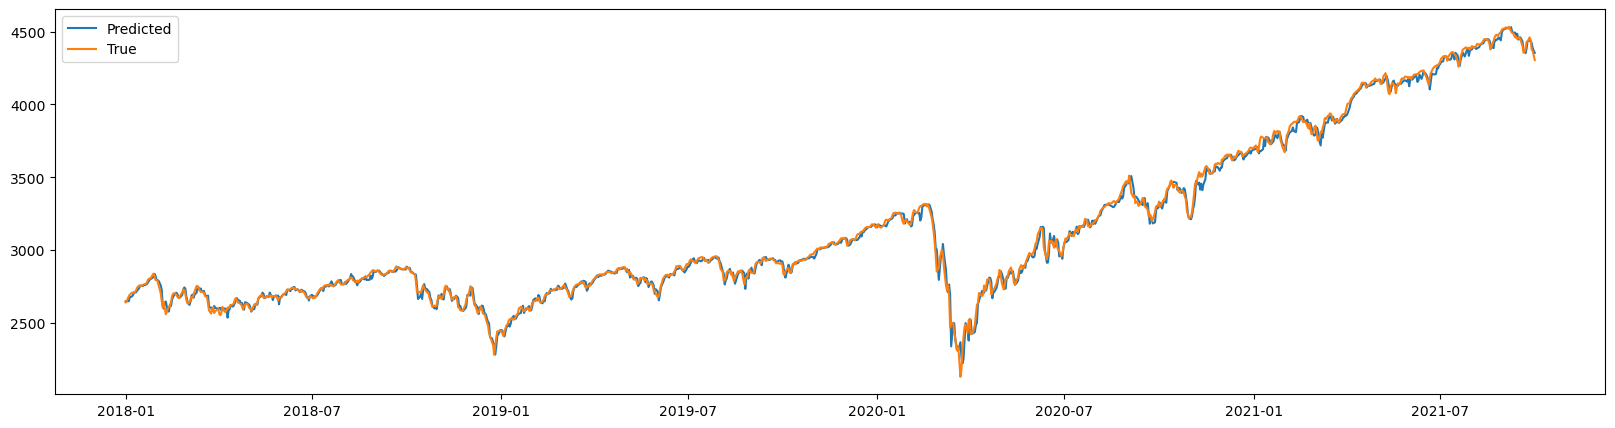

2023-06-17 00:15:19 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-17 00:15:19 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-17 00:15:19 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-17 00:15:19 {'type': 'csvFuturesSimData'} [Warning] No key for csvRollParametersData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-17 00:15:19 {'type': 'csvFuturesSimData'} [Warning] No key for csvSpreadCostData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
1170
1170
COLUMN: NQ ------------------------- 
Datetime
2007-08-20    1982.00000
2007-08-21    1994.6562

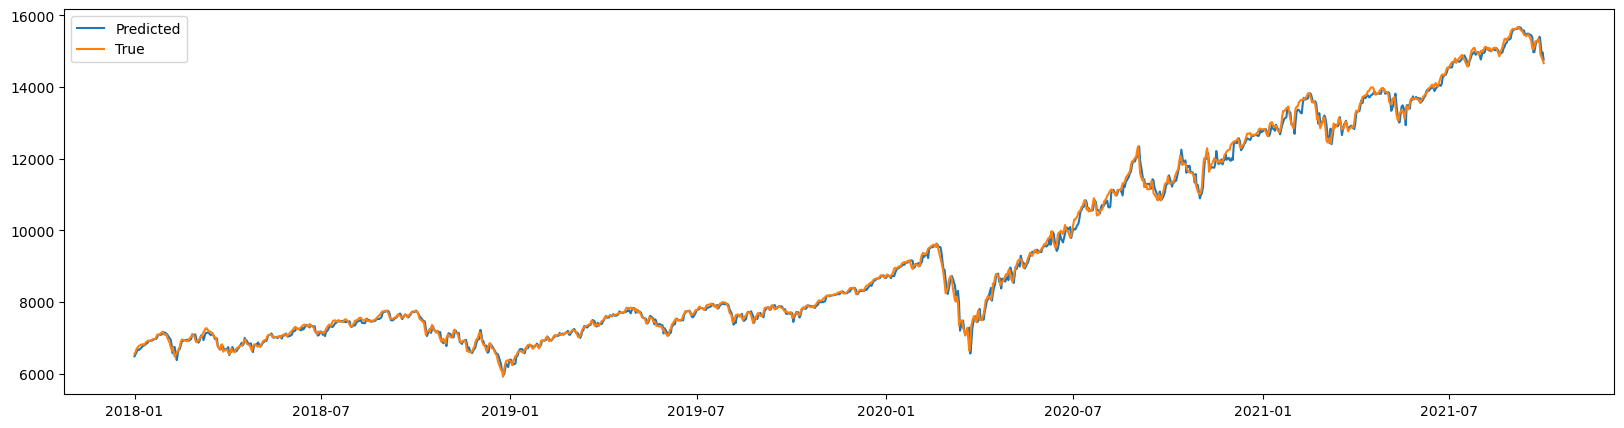

2023-06-17 00:23:37 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-17 00:23:37 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-17 00:23:37 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-17 00:23:37 {'type': 'csvFuturesSimData'} [Warning] No key for csvRollParametersData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-17 00:23:37 {'type': 'csvFuturesSimData'} [Warning] No key for csvSpreadCostData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
1170
1170
COLUMN: FX ------------------------- 
Datetime
2007-08-20    2828.625000
2007-08-21    2825.083

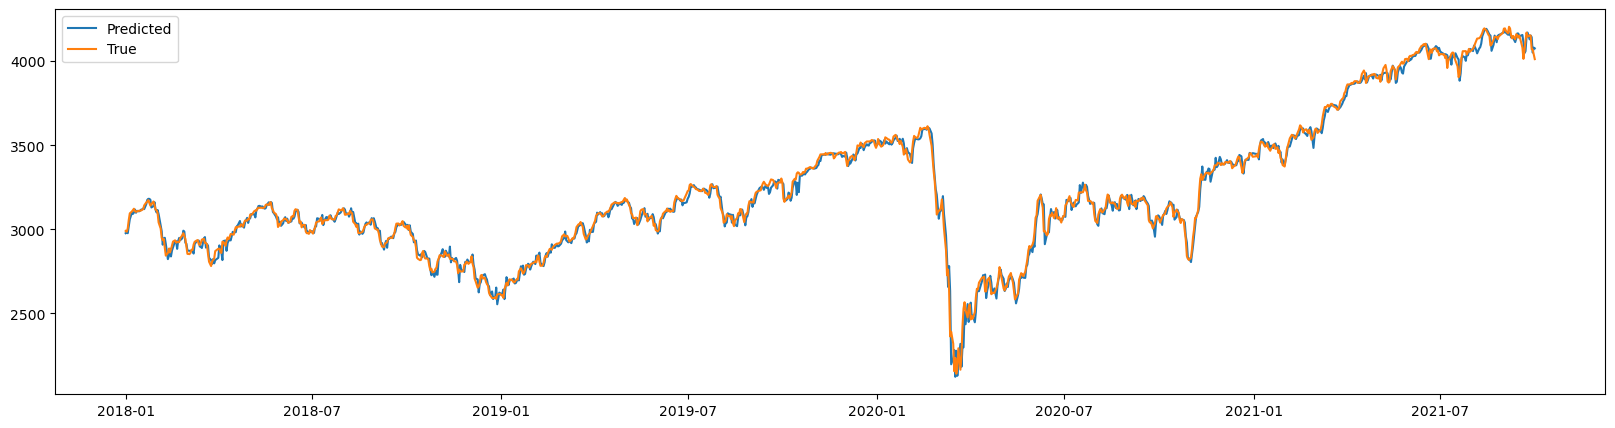

2023-06-17 00:32:26 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-17 00:32:26 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-17 00:32:26 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-17 00:32:26 {'type': 'csvFuturesSimData'} [Warning] No key for csvRollParametersData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-17 00:32:26 {'type': 'csvFuturesSimData'} [Warning] No key for csvSpreadCostData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
1170
1170
COLUMN: DY ------------------------- 
Datetime
2007-08-20    7996.375000
2007-08-21    7982.520

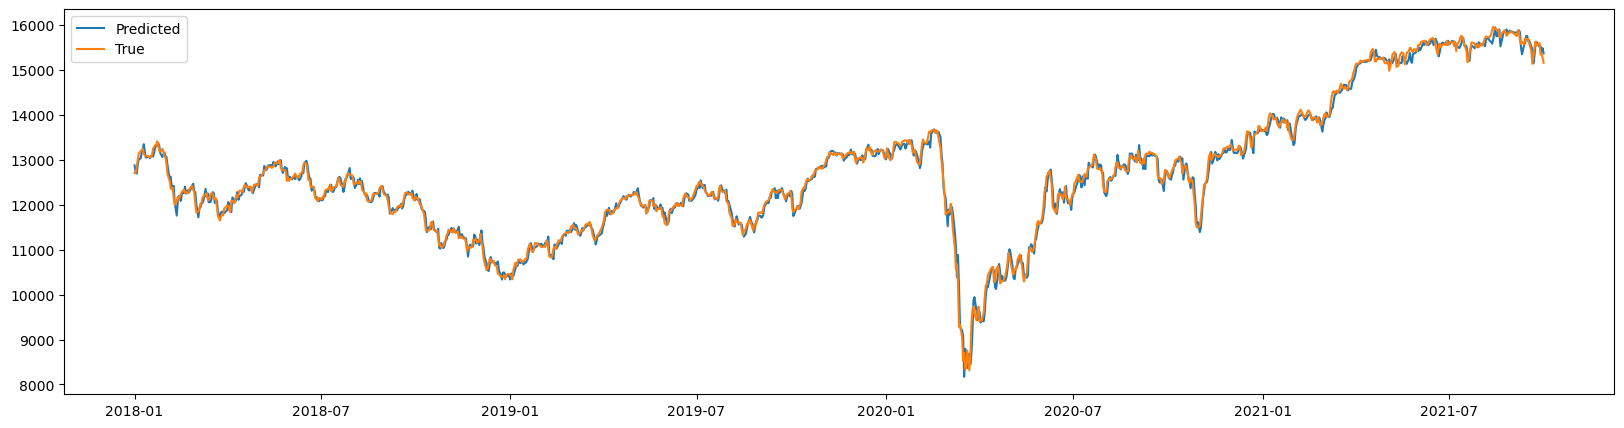

2023-06-17 00:40:55 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-17 00:40:55 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-17 00:40:55 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-17 00:40:55 {'type': 'csvFuturesSimData'} [Warning] No key for csvRollParametersData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-17 00:40:55 {'type': 'csvFuturesSimData'} [Warning] No key for csvSpreadCostData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
1170
1170
COLUMN: X ------------------------- 
Datetime
2007-08-20    3787.78125
2007-08-21    3799.68750

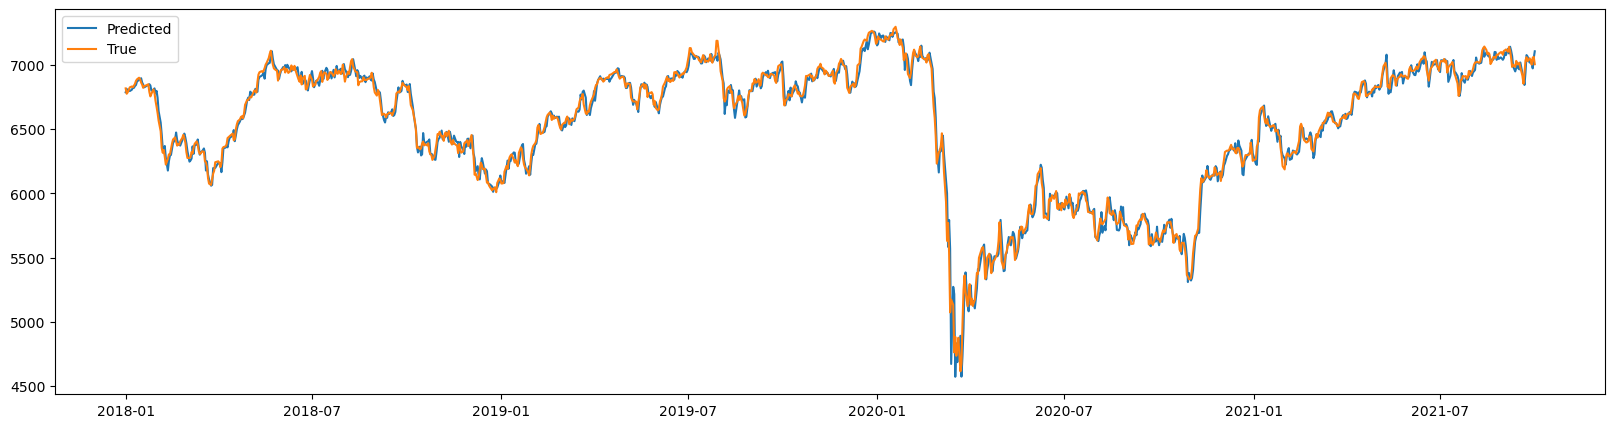

2023-06-17 00:49:27 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-17 00:49:27 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-17 00:49:27 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-17 00:49:27 {'type': 'csvFuturesSimData'} [Warning] No key for csvRollParametersData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-17 00:49:27 {'type': 'csvFuturesSimData'} [Warning] No key for csvSpreadCostData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
1170
1170


In [ ]:
equity_accounts = []
equity_futures_data = pd.read_parquet('../data/equity_indices_first_rate_data_R_prices.parquet')
for i in range(len(equity_futures)):
    print(f"COLUMN: {equity_futures[i]} ------------------------- ")
    curr_futures_data = equity_futures_data[equity_futures[i]]
    
    curr_futures_data_daily_avg = curr_futures_data.resample("D").mean().dropna()

    
    # transform the time series data into supervised learning
    data = transform_series(curr_futures_data, input_seq_len=6)
    
    test_startdate = pd.Timestamp('2018-01-01')
    test_len = len(curr_futures_data_daily_avg[test_startdate:])
    
    mae, y, predictions = walk_forward_validation(data, test_len)
    print('MAE: %.3f' % mae)

    predictions = pd.Series(predictions, index=curr_futures_data_daily_avg.index[-test_len:])
    
    predictions.to_csv(f'../ARIMA-XGBoost-saved-data/{equity_futures[i]}_daily_predictions.csv')
    
    short_test_y = pd.Series(y, index=curr_futures_data_daily_avg.index[-test_len:])

    plt.figure(figsize=(20,5))
    plt.plot(predictions, label='Predicted')
    plt.plot(short_test_y, label='True')
    plt.legend()
    plt.savefig(f'../ARIMA-XGBoost-figs/{equity_futures[i]}_daily_pred_true')
    plt.show()

    forecasts = predictions.diff()

    test_enddate = pd.Timestamp(curr_futures_data_daily_avg.index[-1])

    idx = pd.date_range(test_startdate, test_enddate, freq='D')

    curr_forecast = pd.Series(forecasts)
    curr_forecast.columns = ['forecast']
    curr_forecast.reindex(idx, fill_value=0.0)

    # Convert csv data into data object for pysystemtrade
    instrument_data = csvFuturesSimData(csv_data_paths=dict(csvFuturesAdjustedPricesData="data.firstrate_futures.xgboost"))

        # Get daily prices and calculate the ewmac forecast
    price = instrument_data.get_raw_price(f'{fuel_futures[i]}_daily')
    price_oos = price[test_startdate:test_enddate]
    curr_forecast.reindex(price_oos.index, fill_value=0.0)

    account = pandl_for_instrument_forecast(forecast=curr_forecast, price=price_oos)
    accounts.append(account)


In [ ]:
# figure, axs = plt.subplots(2, 1, figsize=(20, 10))    
fuel_accounts = []
time_steps = 6
for i in range(len(fuel_futures)):    
    fuel_preds = pd.read_csv(f'../ARIMA-XGBoost-saved-data/{fuel_futures[i]}_daily_predictions.csv', parse_dates=True)
    fuel_preds['Datetime'] = pd.to_datetime(fuel_preds['Datetime'])
    fuel_preds = fuel_preds.set_index(['Datetime'])
    
    test_startdate = pd.Timestamp('2018-01-01')
    
    forecasts = fuel_preds.diff()
    futures_data = pd.read_parquet('../data/fuel_first_rate_data_R_prices.parquet')

    # Convert column into csv file
    csv_path = f"../pysystemtrade/data/firstrate_futures/{fuel_futures[i]}.csv"
    futures_data[fuel_futures[i]].to_csv(csv_path, header=["price"])

    # Replaces 'Datetime' with 'DATETIME' in csv file to match with pysystemtrade's data
    in_csv_file = open(csv_path, "r")
    csv_reader = csv.reader(in_csv_file)

    lines = list(csv_reader)
    lines[0][0] = 'DATETIME'  # The cell at (0,0) will always be 'Datetime'

    out_csv_file = open(csv_path, "w")
    csv_writer = csv.writer(out_csv_file)
    csv_writer.writerows(lines)

    in_csv_file.close()
    out_csv_file.close()

    # Convert csv data into data object for pysystemtrade
    instrument_data = csvFuturesSimData(csv_data_paths=dict(csvFuturesAdjustedPricesData="data.firstrate_futures"))

    # Get daily prices and calculate the ewmac forecast
    price = instrument_data.get_raw_price(f'{fuel_futures[i]}_daily')[test_startdate:]
    price = price[time_steps:]
    account = pandl_for_instrument_forecast(forecast=forecasts['0'], price=price)
    fuel_accounts.append(account)

2023-06-21 13:14:04 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-21 13:14:04 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-21 13:14:04 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-21 13:14:04 {'type': 'csvFuturesSimData'} [Warning] No key for csvRollParametersData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-21 13:14:04 {'type': 'csvFuturesSimData'} [Warning] No key for csvSpreadCostData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-21 13:14:04 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in cs

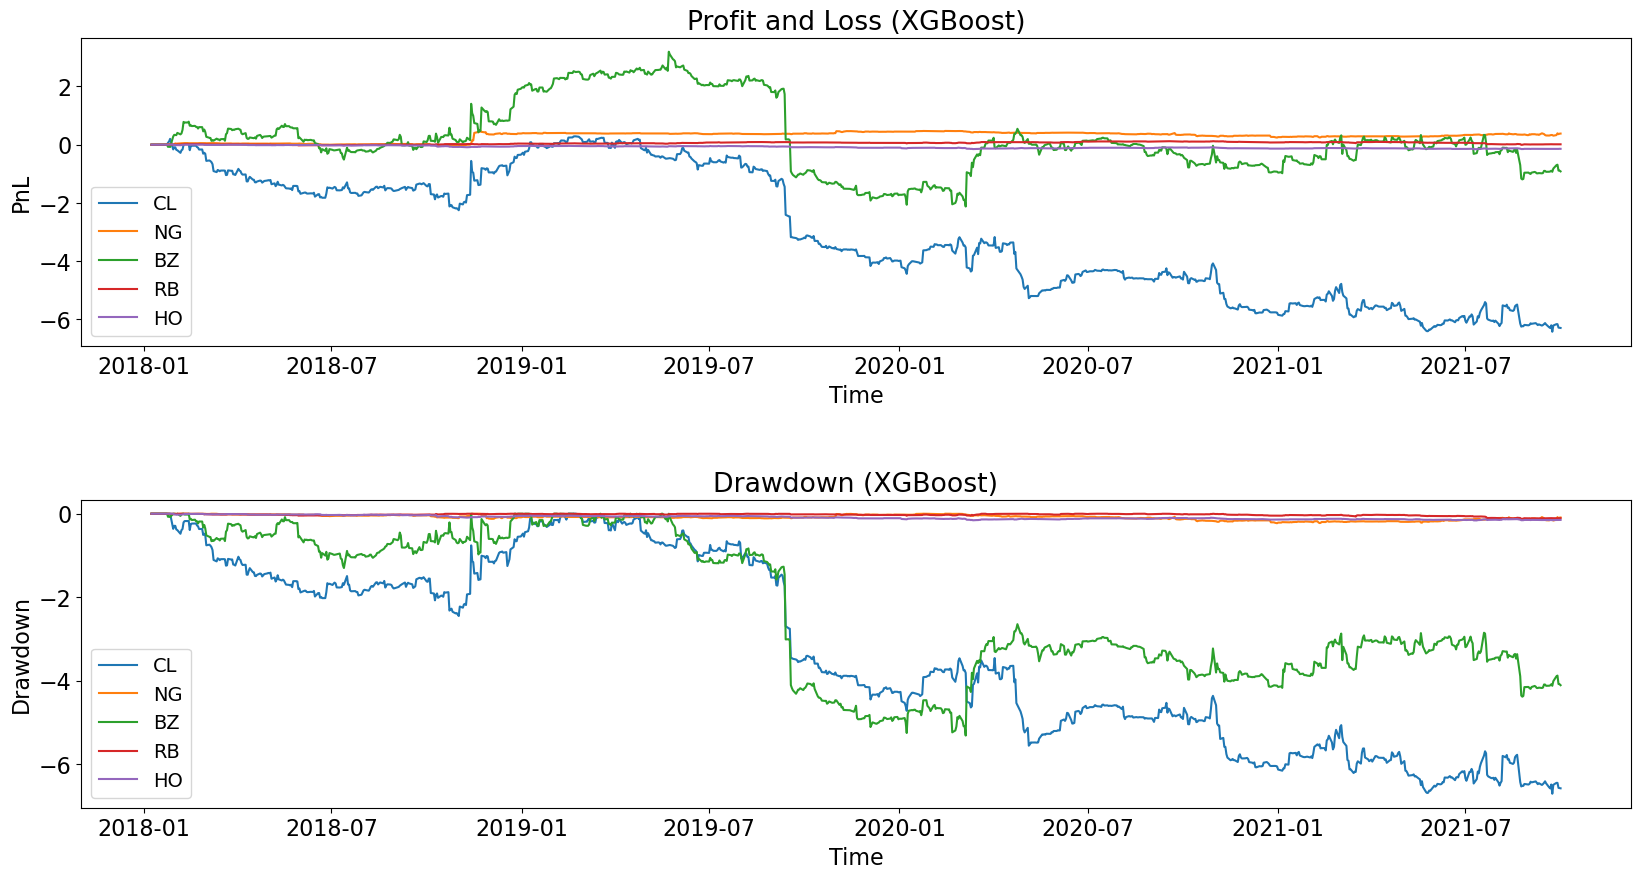

In [ ]:
plt.rcParams.update({
    "font.size": 16,
    "legend.fontsize": 14
})

figure, axs = plt.subplots(2, 1, figsize=(20, 10))
figure.subplots_adjust(hspace=0.5)
for i in range(len(fuel_accounts)):
    axs[0].plot(fuel_accounts[i].curve(), label=f'{fuel_futures[i]}')
    axs[0].title.set_text('Profit and Loss (XGBoost)')
    axs[0].legend()
    axs[0].set_ylabel('PnL')
    axs[0].set_xlabel('Time')

    axs[1].plot(fuel_accounts[i].drawdown(), label=f'{fuel_futures[i]}')
    axs[1].legend()
    axs[1].title.set_text('Drawdown (XGBoost)')
    axs[1].set_ylabel('Drawdown')
    axs[1].set_xlabel('Time')

In [ ]:
fuel_account_statistics = pd.DataFrame(columns=fuel_futures)

for i in range(len(fuel_accounts)):
    
    fuel_account_statistics['STATISTICS'] = pd.Series(list(dict(fuel_accounts[i].percent.stats()[0]).keys()))

    fuel_account_statistics[fuel_futures[i]] = pd.Series([float(x) for x in list(dict(fuel_accounts[i].percent.stats()[0]).values())])
    
    print(round(fuel_accounts[i].curve().iloc[-1], 6))
            
fuel_account_statistics_rounded = fuel_account_statistics.round(decimals=6)
fuel_account_statistics_rounded

-6.290279
0.381605
-0.915932
0.013394
-0.142363


,CL,NG,BZ,RB,HO,STATISTICS
0,-0.964800,-0.065900,-1.556000,-0.023930,-0.039510,min
1,1.161000,0.260500,1.248000,0.026110,0.014690,max
2,-0.000155,0.000000,-0.000215,-0.000002,-0.000021,median
3,-0.006452,0.000391,-0.000939,0.000014,-0.000146,mean
4,0.118600,0.012100,0.135200,0.003358,0.003418,std
5,-0.195300,11.040000,-0.359100,0.193300,-2.129000,skew
6,-1.652000,0.100200,-0.240500,0.003517,-0.037380,ann_mean
7,1.898000,0.193600,2.164000,0.053730,0.054690,ann_std
8,-0.870100,0.517500,-0.111100,0.065460,-0.683500,sharpe
9,-0.978100,0.947100,-0.128300,0.083380,-0.725000,sortino


In [ ]:
# figure, axs = plt.subplots(2, 1, figsize=(20, 10))    
equity_accounts = []
time_steps = 6
for i in range(len(equity_futures)):    
    eq_preds = pd.read_csv(f'../ARIMA-XGBoost-saved-data/{equity_futures[i]}_daily_predictions.csv', parse_dates=True)
    eq_preds['Datetime'] = pd.to_datetime(eq_preds['Datetime'])
    eq_preds = eq_preds.set_index(['Datetime'])
    
    test_startdate = pd.Timestamp('2018-01-01')
    
    forecasts = eq_preds.diff()
    futures_data = pd.read_parquet('../data/equity_indices_first_rate_data_R_prices.parquet')

    # Convert column into csv file
    csv_path = f"../pysystemtrade/data/firstrate_futures/{equity_futures[i]}.csv"
    futures_data[equity_futures[i]].to_csv(csv_path, header=["price"])

    # Replaces 'Datetime' with 'DATETIME' in csv file to match with pysystemtrade's data
    in_csv_file = open(csv_path, "r")
    csv_reader = csv.reader(in_csv_file)

    lines = list(csv_reader)
    lines[0][0] = 'DATETIME'  # The cell at (0,0) will always be 'Datetime'

    out_csv_file = open(csv_path, "w")
    csv_writer = csv.writer(out_csv_file)
    csv_writer.writerows(lines)

    in_csv_file.close()
    out_csv_file.close()

    # Convert csv data into data object for pysystemtrade
    instrument_data = csvFuturesSimData(csv_data_paths=dict(csvFuturesAdjustedPricesData="data.firstrate_futures"))

    # Get daily prices and calculate the ewmac forecast
    price = instrument_data.get_raw_price(f'{equity_futures[i]}_daily')[test_startdate:]
    price = price[time_steps:]
    account = pandl_for_instrument_forecast(forecast=forecasts['0'], price=price)
    equity_accounts.append(account)

2023-06-21 13:14:31 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-21 13:14:31 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-21 13:14:31 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-21 13:14:31 {'type': 'csvFuturesSimData'} [Warning] No key for csvRollParametersData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-21 13:14:31 {'type': 'csvFuturesSimData'} [Warning] No key for csvSpreadCostData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-21 13:14:31 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in cs

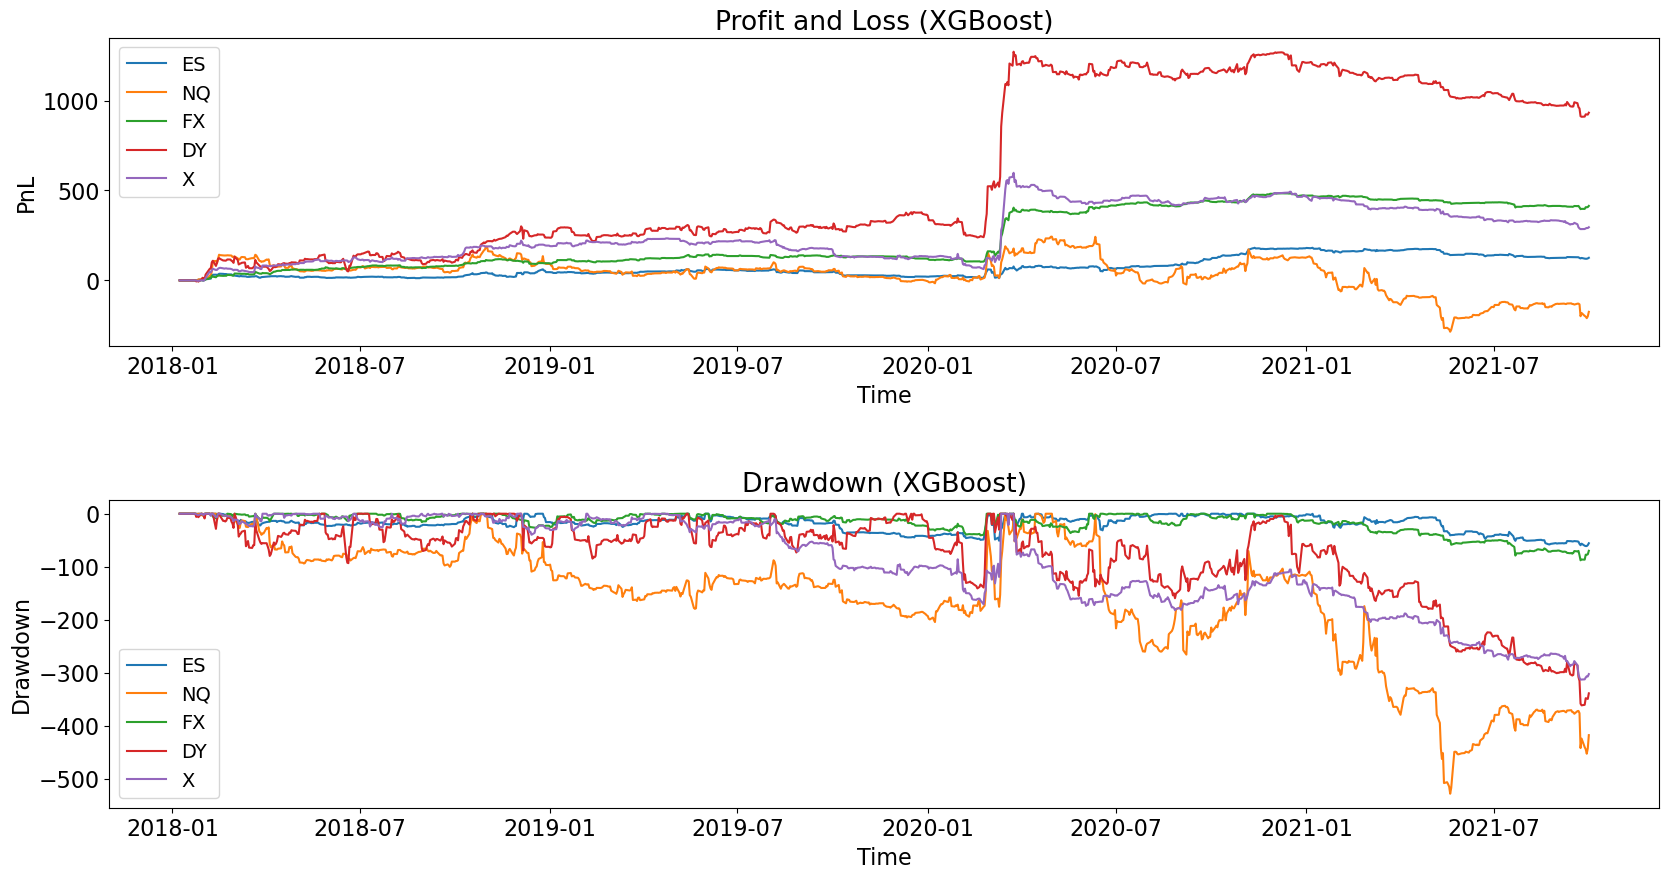

In [ ]:
plt.rcParams.update({
    "font.size": 16,
    "legend.fontsize": 14
})

figure, axs = plt.subplots(2, 1, figsize=(20, 10))
figure.subplots_adjust(hspace=0.5)
for i in range(len(equity_accounts)):
    axs[0].plot(equity_accounts[i].curve(), label=f'{equity_futures[i]}')
    axs[0].title.set_text('Profit and Loss (XGBoost)')
    axs[0].legend()
    axs[0].set_ylabel('PnL')
    axs[0].set_xlabel('Time')

    axs[1].plot(equity_accounts[i].drawdown(), label=f'{equity_futures[i]}')
    axs[1].legend()
    axs[1].title.set_text('Drawdown (XGBoost)')
    axs[1].set_ylabel('Drawdown')
    axs[1].set_xlabel('Time')

In [ ]:
equity_account_statistics = pd.DataFrame(columns=equity_futures)

for i in range(len(equity_accounts)):
    
    equity_account_statistics['STATISTICS'] = pd.Series(list(dict(equity_accounts[i].percent.stats()[0]).keys()))

    equity_account_statistics[equity_futures[i]] = pd.Series([float(x) for x in list(dict(equity_accounts[i].percent.stats()[0]).values())])
    
    print(round(equity_accounts[i].curve().iloc[-1], 6))
            
equity_account_statistics_rounded = equity_account_statistics.round(decimals=6)
equity_account_statistics_rounded

125.620017
-174.971323
414.233571
932.588213
295.564628


,ES,NQ,FX,DY,X,STATISTICS
0,-25.42000,-86.03000,-22.740000,-64.15000,-51.7200,min
1,31.44000,78.68000,82.770000,279.70000,207.6000,max
2,0.03296,0.00000,0.000000,0.00000,0.0000,median
3,0.12880,-0.17950,0.424900,0.95650,0.3031,mean
4,3.20200,12.60000,5.024000,17.43000,10.3500,std
5,0.83170,-0.14210,7.823000,6.12800,11.0900,skew
6,32.98000,-45.94000,108.800000,244.90000,77.6000,ann_mean
7,51.23000,201.50000,80.380000,278.90000,165.6000,ann_std
8,0.64380,-0.22800,1.353000,0.87810,0.4687,sharpe
9,0.79050,-0.26040,2.776000,1.56800,0.8952,sortino


In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
import csv

2023-06-15 23:45:34 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-15 23:45:34 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-15 23:45:34 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-15 23:45:34 {'type': 'csvFuturesSimData'} [Warning] No key for csvRollParametersData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-15 23:45:34 {'type': 'csvFuturesSimData'} [Warning] No key for csvSpreadCostData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
Datetime
2021-09-27 09:00:00    79.31
2021-09-27 10:00:00    78.99
2021-09-27 11:00:00    78.75
2021-09-2

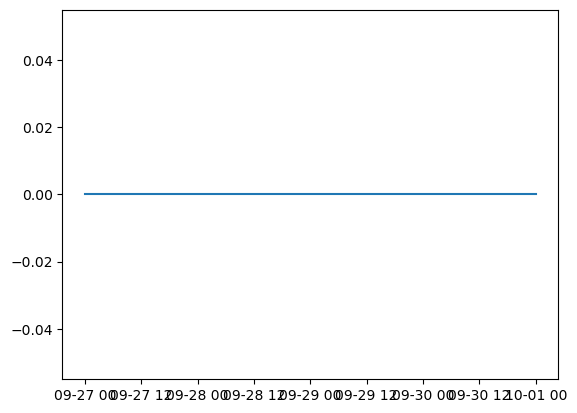

In [ ]:
sys.path.append(os.path.abspath('../pysystemtrade'))
# test_startdate = pd.Timestamp(curr_futures_data.index[-test_len])
test_startdate = pd.Timestamp('2018-01-02')

test_enddate = pd.Timestamp(curr_futures_data.index[-1])

from sysdata.sim.csv_futures_sim_data import csvFuturesSimData
from sysquant.estimators.vol import robust_vol_calc
from systems.accounts.account_forecast import pandl_for_instrument_forecast

predictions = pd.read_csv('../ARIMA-XGBoost-saved-data/BZ_predictions.csv', parse_dates=['Datetime'])
predictions['Datetime'] = pd.to_datetime(predictions['Datetime'])
predictions = predictions.set_index(['Datetime'])

####### Code from ARIMA-CNN-LSTM
forecasts = predictions.diff()
curr_futures_data = futures_data[fuel_futures[i]]

source_dataframe = pd.read_parquet('../data/fuel_first_rate_data_R_prices.parquet')

i = 2
column = fuel_futures[i]

# Convert column into csv file
csv_path = f"../pysystemtrade/data/firstrate_futures/{fuel_futures[i]}.csv"
futures_data[fuel_futures[i]].to_csv(csv_path, header=["price"])

# Replaces 'Datetime' with 'DATETIME' in csv file to match with pysystemtrade's data
in_csv_file = open(csv_path, "r")
csv_reader = csv.reader(in_csv_file)

lines = list(csv_reader)
lines[0][0] = 'DATETIME'  # The cell at (0,0) will always be 'Datetime'

out_csv_file = open(csv_path, "w")
csv_writer = csv.writer(out_csv_file)
csv_writer.writerows(lines)

in_csv_file.close()
out_csv_file.close()

# Convert csv data into data object for pysystemtrade
instrument_data = csvFuturesSimData(csv_data_paths=dict(csvFuturesAdjustedPricesData="data.firstrate_futures"))

# Get daily prices and calculate the ewmac forecast
price = instrument_data.get_raw_price(column)[test_startdate:]

price = curr_futures_data[test_startdate:]
# price = price[time_steps:]
print(pd.Series(price))
print(pd.Series(forecasts['0']))

price_series = pd.Series(price)
price_series.name = 'price'

forecasts_series = pd.Series(forecasts['0'])
forecasts_series.name = 'price'

#     short_test_y_pd = pd.DataFrame(short_test_y, index=short_test_set.index[time_steps:])

account = pandl_for_instrument_forecast(forecast=forecasts_series, price=price_series)
# accounts.append(account)

plt.figure()
plt.plot(account.curve(), label={fuel_futures[i]})
plt.savefig(f'../ARIMA-CNN-LSTM-figs/{fuel_futures[i]}_pnl')
plt.show()
############ END of code from ARIMA-CNN-LSTM

In [ ]:
print(predictions)

                             0
Datetime                      
2021-09-27 09:00:00  78.948944
2021-09-27 10:00:00  79.076935
2021-09-27 11:00:00  79.154550
2021-09-27 12:00:00  78.578740
2021-09-27 13:00:00  78.998330
...                        ...
2021-10-01 12:00:00  78.544426
2021-10-01 13:00:00  78.780780
2021-10-01 14:00:00  79.046540
2021-10-01 15:00:00  79.038500
2021-10-01 16:00:00  79.139830

[100 rows x 1 columns]


In [ ]:
print(price_series)

Datetime
2021-09-27 09:00:00    79.31
2021-09-27 10:00:00    78.99
2021-09-27 11:00:00    78.75
2021-09-27 12:00:00    79.04
2021-09-27 13:00:00    79.15
                       ...  
2021-10-01 12:00:00    78.82
2021-10-01 13:00:00    79.34
2021-10-01 14:00:00    79.14
2021-10-01 15:00:00    79.14
2021-10-01 16:00:00    79.12
Name: price, Length: 100, dtype: float64


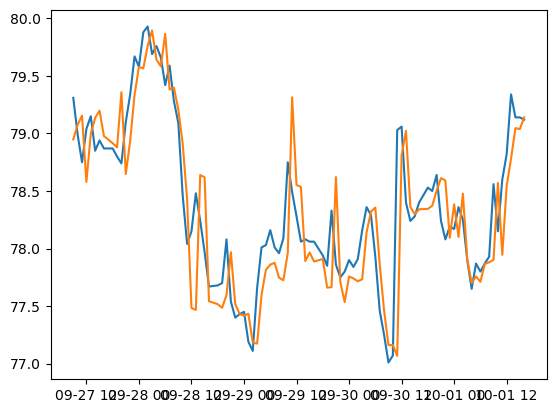

In [ ]:
plt.figure()
plt.plot(price_series)
plt.plot(predictions)
plt.show()

In [ ]:
curr_forecast

Datetime
2021-09-27 09:00:00         NaN
2021-09-27 10:00:00    0.127991
2021-09-27 11:00:00    0.077615
2021-09-27 12:00:00   -0.575810
2021-09-27 13:00:00    0.419590
                         ...   
2021-10-01 12:00:00    0.598726
2021-10-01 13:00:00    0.236354
2021-10-01 14:00:00    0.265760
2021-10-01 15:00:00   -0.008040
2021-10-01 16:00:00    0.101330
Name: price, Length: 100, dtype: float64

In [ ]:
curr_forecast = curr_forecast.where(curr_forecast > 0.0, -1.0)
curr_forecast

Datetime
2021-09-27 09:00:00   -1.000000
2021-09-27 10:00:00    0.127991
2021-09-27 11:00:00    0.077615
2021-09-27 12:00:00   -1.000000
2021-09-27 13:00:00    0.419590
                         ...   
2021-10-01 12:00:00    0.598726
2021-10-01 13:00:00    0.236354
2021-10-01 14:00:00    0.265760
2021-10-01 15:00:00   -1.000000
2021-10-01 16:00:00    0.101330
Name: price, Length: 100, dtype: float64

In [ ]:
curr_forecast = curr_forecast.where(curr_forecast < 0.0, 1.0)
curr_forecast

Datetime
2021-09-27 09:00:00   -1.0
2021-09-27 10:00:00    1.0
2021-09-27 11:00:00    1.0
2021-09-27 12:00:00   -1.0
2021-09-27 13:00:00    1.0
                      ... 
2021-10-01 12:00:00    1.0
2021-10-01 13:00:00    1.0
2021-10-01 14:00:00    1.0
2021-10-01 15:00:00   -1.0
2021-10-01 16:00:00    1.0
Name: price, Length: 100, dtype: float64

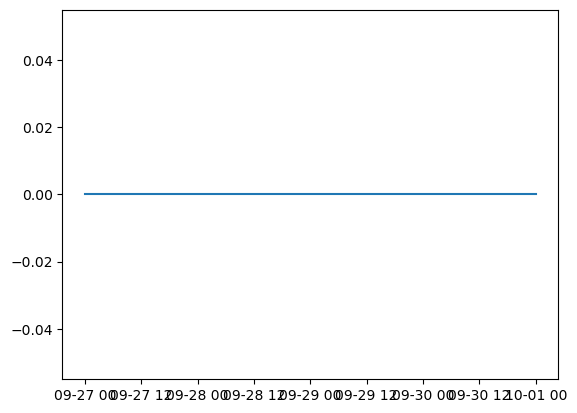

In [ ]:
account = pandl_for_instrument_forecast(forecast=curr_forecast, price=price_oos)
plt.plot(account.curve())

[Datetime
2021-09-27    0.0
2021-09-28    0.0
2021-09-29    0.0
2021-09-30    0.0
2021-10-01    0.0
Freq: B, dtype: float64
 Unweighted account curve; use object.stats() to see methods]


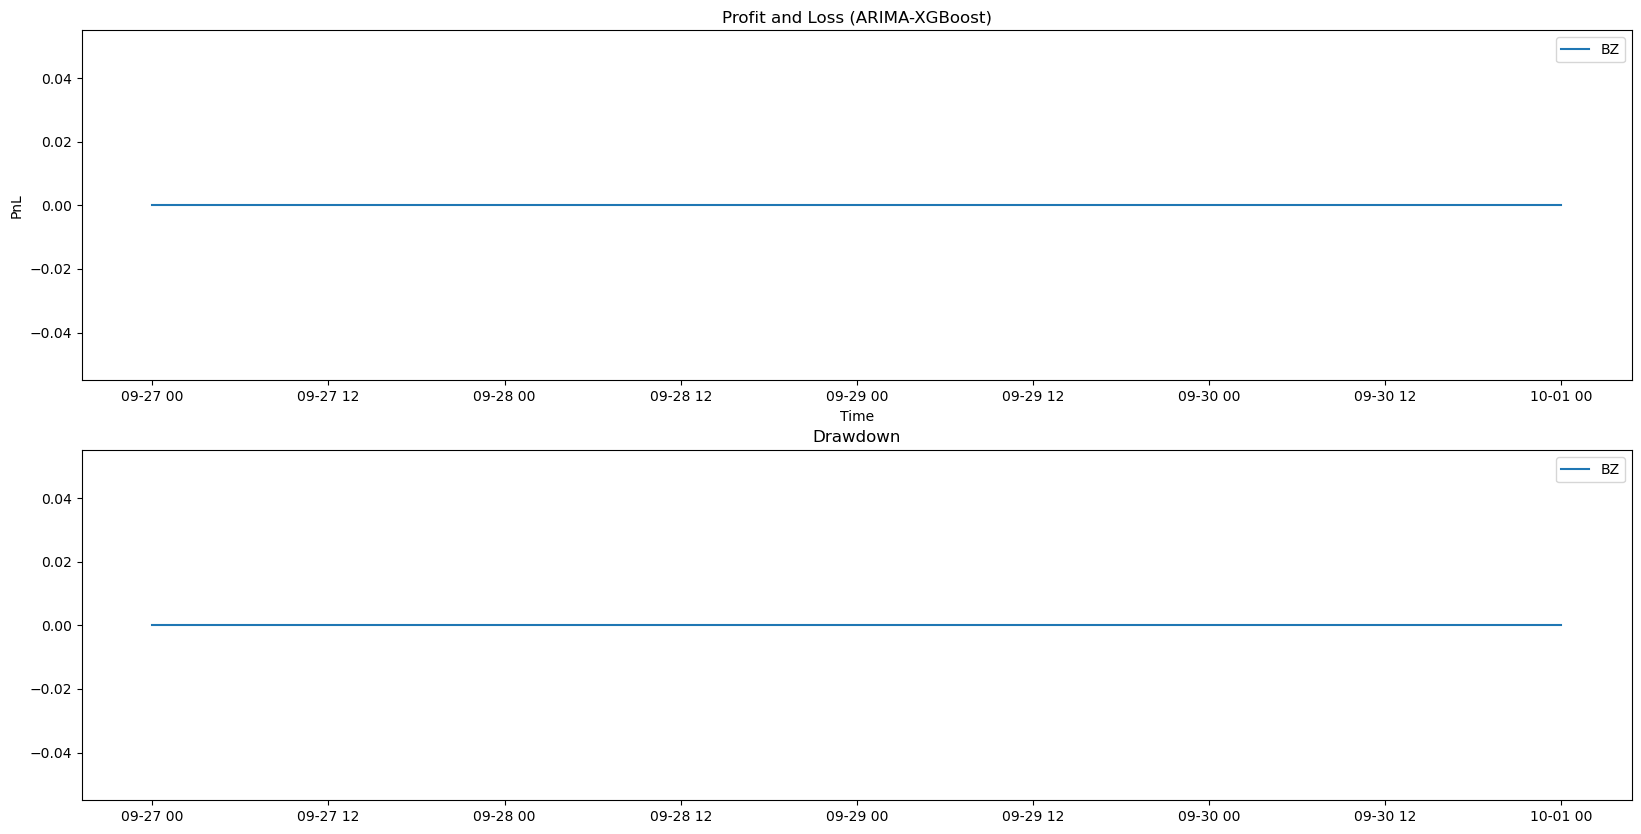

In [ ]:
figure, axs = plt.subplots(2, 1, figsize=(20, 10))   
print(accounts)
for i in range(len(accounts)):
    axs[0].plot(accounts[i].curve(), label=f'BZ')
    axs[0].title.set_text('Profit and Loss (ARIMA-XGBoost)')
    axs[0].legend()
    axs[0].set_ylabel('PnL')
    axs[0].set_xlabel('Time')

    axs[1].plot(accounts[i].drawdown(), label=f'BZ')
    axs[1].legend()
    axs[1].title.set_text('Drawdown')

In [ ]:
curr_forecast = all_forecast[0]
print(type(curr_forecast))
curr_forecast_df = pd.DataFrame(curr_forecast, columns=['forecast'])
print(curr_forecast)

price = curr_futures_data.iloc[-test_len:]
price.name = 'price'

print(price)
print(type(price))

instrument_data = csvFuturesSimData(csv_data_paths=dict(csvFuturesAdjustedPricesData="data.firstrate_futures"))

# Get daily prices and calculate the ewmac forecast
price = instrument_data.get_raw_price('BZ').iloc[-test_len:]

account = pandl_for_instrument_forecast(forecast=curr_forecast, price=price)
print(account)

<class 'pandas.core.series.Series'>
Datetime
2021-09-27 09:00:00         NaN
2021-09-27 10:00:00    0.127991
2021-09-27 11:00:00    0.077614
2021-09-27 12:00:00   -0.575806
2021-09-27 13:00:00    0.419586
                         ...   
2021-10-01 12:00:00    0.598724
2021-10-01 13:00:00    0.236351
2021-10-01 14:00:00    0.265762
2021-10-01 15:00:00   -0.008041
2021-10-01 16:00:00    0.101334
Length: 100, dtype: float32
Datetime
2021-09-27 09:00:00    79.31
2021-09-27 10:00:00    78.99
2021-09-27 11:00:00    78.75
2021-09-27 12:00:00    79.04
2021-09-27 13:00:00    79.15
                       ...  
2021-10-01 12:00:00    78.82
2021-10-01 13:00:00    79.34
2021-10-01 14:00:00    79.14
2021-10-01 15:00:00    79.14
2021-10-01 16:00:00    79.12
Name: price, Length: 100, dtype: float64
<class 'pandas.core.series.Series'>
2023-06-15 17:29:03 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should 

In [ ]:
account_statistics = pd.DataFrame(columns=['BZ'])

for i in range(len(accounts)):
    
    account_statistics['STATISTICS'] = pd.Series(list(dict(accounts[i].percent.stats()[0]).keys()))

    account_statistics['BZ'] = pd.Series([float(x) for x in list(dict(accounts[i].percent.stats()[0]).values())])
    
    print(round(accounts[i].curve().iloc[-1], 6))
            
account_statistics_rounded = account_statistics.round(decimals=6)
account_statistics_rounded

/rds/general/user/zm520/home/anaconda3/envs/mlproject2/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/zm520/home/anaconda3/envs/mlproject2/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/rds/general/user/zm520/home/anaconda3/envs/mlproject2/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/rds/general/user/zm520/home/pysystemtrade/systems/accounts/curves/account_curve.py:262: RuntimeWarning: invalid value encountered in double_scalars
  return self.ann_mean() / -self.worst_drawdown()
/rds/general/user/zm520/home/pysystemtrade/systems/accounts/curves/account_curve.py:265: RuntimeWarning: invalid value encountered i

ZeroDivisionError: float division by zero